In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import LogisticRegression

In [2]:
# read in cleaned CSV
filepath = Path('massive.csv')
massive = pd.read_csv(filepath)
massive = massive.sample(n=15000)

In [3]:
massive.head(1)

,title,criticName,publicatioName,reviewText,scoreSentiment,delta
408720,10 Things I Hate About You,Doris Toumarkine,Film Journal International,A routine exercise in teen-targeted silliness.,NEGATIVE,2.0


In [5]:
# Lemmatization of reviews
# define a function to process text
lemmatizer = WordNetLemmatizer()
import re
def process_text(text): 
    sw = set(stopwords.words('english')) 
    regex = re.compile("[^a-zA-Z ]") 
    re_clean = regex.sub('', text) 
    words = word_tokenize(re_clean) 
    lem = [lemmatizer.lemmatize(word) for word in words] 
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw]) 
    return output

In [6]:
# use a lambda x function to apply process on the whole 'reviewText' column.
massive['reviewText'] = massive['reviewText'].apply(lambda x: process_text(x))

In [7]:
# TF-IDF sentiment model
# fit vectorizer on reviews with critic sentiment as target
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(massive['reviewText'])
y = massive['scoreSentiment']

In [8]:
# Split the data into training and testing sets for sentiment model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [9]:
model.score(X_train, y_train)

0.8237333333333333

In [10]:
model.score(X_test, y_test)

0.76

In [14]:
# Rename 'title' to prevent problems with vector or dummy columns
massive = massive.rename(columns={'title': 'title_'})

In [15]:
# Vectorizing original review text to dense array for linear model
tfidf_dense = tfidf_vectorizer.fit_transform(massive['reviewText']).todense()

# Naming columns for each vectorized word and combining with original dataframe
new_cols = tfidf_vectorizer.get_feature_names()
combined = massive.join(pd.DataFrame(tfidf_dense, columns=new_cols))

/Users/jim/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


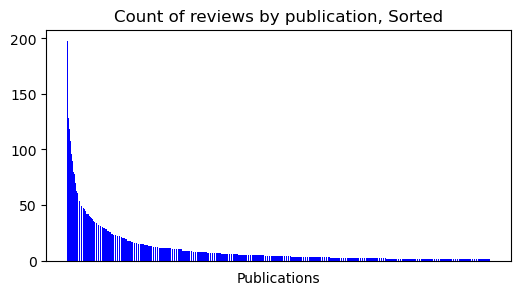

In [16]:
#Limiting populations of critics and publications
# Histogram of reviews per publication
# Sort the 'publicatioName' column
publication_sorted = massive['publicatioName'].value_counts().reset_index().rename(
    columns={'index': 'publicatioName', 'publicatioName': 'count'})
publication_sorted = publication_sorted.sort_values(by='count', ascending=False)

# Set the figure size
plt.figure(figsize=(6, 3))

# Create a bar plot using Matplotlib
plt.bar(publication_sorted['publicatioName'], publication_sorted['count'], color='blue')

# Set the title
plt.title('Count of reviews by publication, Sorted')

# Remove x-axis labels
plt.xticks([])

# Set the x and y-axis labels
plt.xlabel('Publications')
plt.ylabel('')

# Save the plot as an image
plt.savefig("output_plots/histo_publicatioName.png")

# Show the plot
plt.show()


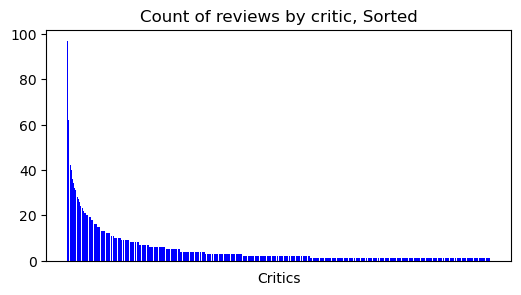

In [17]:
# Histogram of reviews per critic
# Sort the 'criticName' column
critic_sorted = massive['criticName'].value_counts().reset_index().rename(
    columns={'index': 'criticName', 'criticName': 'count'})
critic_sorted = critic_sorted.sort_values(by='count', ascending=False)

# Set the figure size
plt.figure(figsize=(6, 3))

# Create a bar plot using Matplotlib
plt.bar(critic_sorted['criticName'], critic_sorted['count'], color='blue')

# Set the title
plt.title('Count of reviews by critic, Sorted')

# Remove x-axis labels
plt.xticks([])

# Set the x and y-axis labels
plt.xlabel('Critics')
plt.ylabel('')

# Save the plot as an image
plt.savefig("output_plots/histo_criticName.png")

# Show the plot
plt.show()


In [18]:
# Grouping bottom publications as Other to be encoded into one
counts = combined.publicatioName.value_counts()
threshold = combined.publicatioName.isin(counts.index[counts<12])
combined.loc[threshold, 'publicatioName'] = 'Other'
combined['publicatioName'].value_counts()

Other                 4300
New York Times         198
Variety                164
Los Angeles Times      144
Hollywood Reporter     128
                      ... 
Daily Film Fix          12
Sin Magazine            12
Schmoes Know            12
sbs.com.au              12
Patrick Nabarro         12
Name: publicatioName, Length: 325, dtype: int64

In [19]:
# Grouping bottom critics as Other to be encoded into one
counts = combined.criticName.value_counts()
threshold = combined.criticName.isin(counts.index[counts<16])
combined.loc[threshold, 'criticName'] = 'Other'
combined['criticName'].value_counts()

Other              8929
David Nusair         97
Dennis Schwartz      96
Roger Ebert          88
Frank Swietek        78
                   ... 
Geoffrey Macnab      16
Jennie Kermode       16
Chris Bumbray        16
Brian Webster        16
Mike Clark           16
Name: criticName, Length: 221, dtype: int64

In [20]:
# Dropping review text now that vectorized words are all columns
combined = combined.drop(columns=['reviewText'])
combined.head(1)

,title_,criticName,publicatioName,scoreSentiment,delta,aaron,ability,able,absolute,absolutely,...,young,younger,youngster,youre,youth,youve,zero,zhang,zombie,zone
408720,10 Things I Hate About You,Other,Film Journal International,NEGATIVE,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
combined = combined.fillna(0)

In [22]:
combined.isnull().sum().head(9)

title_            0
criticName        0
publicatioName    0
scoreSentiment    0
delta             0
aaron             0
ability           0
able              0
absolute          0
dtype: int64

In [23]:
# columns to dummy
categorical_cols = ['title_', 'criticName', 'publicatioName', 'scoreSentiment'] 
# get dummies
combined = pd.get_dummies(combined, columns = categorical_cols)

In [24]:
X = combined.drop(columns=['delta'])
y = combined['delta']

In [25]:
X.isnull().sum()

aaron                                     0
ability                                   0
able                                      0
absolute                                  0
absolutely                                0
                                         ..
publicatioName_rec.arts.movies.reviews    0
publicatioName_sbs.com.au                 0
publicatioName_tonymacklin.net            0
scoreSentiment_NEGATIVE                   0
scoreSentiment_POSITIVE                   0
Length: 13337, dtype: int64

In [26]:
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
X_train.isnull().sum()

aaron                                     0
ability                                   0
able                                      0
absolute                                  0
absolutely                                0
                                         ..
publicatioName_rec.arts.movies.reviews    0
publicatioName_sbs.com.au                 0
publicatioName_tonymacklin.net            0
scoreSentiment_NEGATIVE                   0
scoreSentiment_POSITIVE                   0
Length: 13337, dtype: int64

In [28]:
X_train.head()

,aaron,ability,able,absolute,absolutely,absorbing,absurd,absurdity,absurdly,abuse,...,publicatioName_eFilmCritic.com,publicatioName_eye WEEKLY,publicatioName_film-authority.com,publicatioName_indieWire,publicatioName_jackiekcooper.com,publicatioName_rec.arts.movies.reviews,publicatioName_sbs.com.au,publicatioName_tonymacklin.net,scoreSentiment_NEGATIVE,scoreSentiment_POSITIVE
901029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
651330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
893016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
45578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
50002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
X_train.tail()

,aaron,ability,able,absolute,absolutely,absorbing,absurd,absurdity,absurdly,abuse,...,publicatioName_eFilmCritic.com,publicatioName_eye WEEKLY,publicatioName_film-authority.com,publicatioName_indieWire,publicatioName_jackiekcooper.com,publicatioName_rec.arts.movies.reviews,publicatioName_sbs.com.au,publicatioName_tonymacklin.net,scoreSentiment_NEGATIVE,scoreSentiment_POSITIVE
802002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
47925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
45622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
470338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
660607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
# Choose a machine learning model (e.g., Logistic Regression) and train it
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
model.score(X_test, y_test)

-6.395684360199288e+21